## Setup

In [115]:
!conda install keras

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.12
  latest version: 4.7.11

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.



In [85]:
import numpy as np
import pandas as pd
import h5py
import os
import sagemaker
import boto3
import botocore

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline
import matplotlib.pyplot as plt

from sagemaker.tensorflow import TensorFlow
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.analytics import TrainingJobAnalytics

from cnn import FashionMNISTCNN as fmc

## Download and store data locally

In [27]:
# Get data
X_train, Y_train, X_val, Y_val = fmc.load_data()

## Upload data to s3

In [49]:
sess = sagemaker.Session()
role_name = sagemaker.get_execution_role()
bucket_name = 'sagemaker-fashion-mnist'

In [50]:
training_input_path   = sess.upload_data('data/train.hdf5', bucket=bucket_name, key_prefix='data')
validation_input_path = sess.upload_data('data/val.hdf5', bucket=bucket_name, key_prefix='data')

In [51]:
print(training_input_path)
print(validation_input_path)

s3://sagemaker-fashion-mnist/data/train.hdf5
s3://sagemaker-fashion-mnist/data/val.hdf5


## Train locally to test training script

In [ ]:
# local directory for sagemaker job results
sm_output_dir = os.path.join(os.getcwd(), 'sagemaker_output')
os.makedirs(sm_output_dir, exist_ok=True)

In [31]:
# upload folder to s3 
sm_output_path = sess.upload_data('sagemaker_output/', bucket=bucket_name, key_prefix='sm-output')

print(sm_output_path)

s3://sagemaker-fashion-mnist/sm-output


In [54]:
# metrics to watch
metric_defs = [ {'Name': 'acc',
                       'Regex': 'acc: ([0-9\\.]+)'},
                       {'Name': 'val_acc',
                       'Regex': 'val_acc: ([0-9\\.]+)'}]


hyperparams = {'epochs': 1, 'batch-size': 128}

# sagemaker estimator
tf_estimator = TensorFlow(entry_point='train_script_sagemaker.py', 
                          role=role_name,
                          train_volume_size=1,
                          train_instance_count=1, 
                          train_instance_type='local',
                          model_dir=sm_output_path,
                          hyperparameters=hyperparams,
                          metric_definitions=metric_defs,
                          framework_version='1.13', 
                          py_version='py3',
                          script_mode=True,
                         )

In [56]:
# train estimator
input_paths = {'training': training_input_path, 'validation': validation_input_path}
tf_estimator.fit(input_paths)

Creating tmp__k6nxhp_algo-1-jncbe_1 ... 
Attaching to tmp__k6nxhp_algo-1-jncbe_12mdone
algo-1-jncbe_1  | 2019-09-14 21:36:22,683 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
algo-1-jncbe_1  | 2019-09-14 21:36:22,691 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-jncbe_1  | 2019-09-14 21:36:22,896 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-jncbe_1  | 2019-09-14 21:36:22,919 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-jncbe_1  | 2019-09-14 21:36:22,941 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
algo-1-jncbe_1  | 2019-09-14 21:36:22,957 sagemaker-containers INFO     Invoking user script
algo-1-jncbe_1  | 
algo-1-jncbe_1  | Training Env:
algo-1-jncbe_1  | 
algo-1-jncbe_1  | {
algo-1-jncbe_1  |     "additional_framework_parameters": {},
algo-1-jncbe_1  |     "channel_input_dirs": {
algo-1-jncbe_1  

## Train on spot instances

In [57]:
# objective and metric
metric_definitions = [ {'Name': 'acc',
                       'Regex': 'acc: ([0-9\\.]+)'},
                       {'Name': 'val_acc',
                       'Regex': 'val_acc: ([0-9\\.]+)'}]


hyperparameters = {'epochs': 100, 'batch-size': 128}

# sagemaker estimator
tf_estimator = TensorFlow(entry_point='train_script_sagemaker.py', 
                          role=role_name,
                          train_volume_size=1,
                          train_instance_count=1, 
                          train_instance_type='ml.m5.xlarge',
                          train_use_spot_instances=True,
                          train_max_wait=86400,
                          model_dir=sm_output_path,
                          framework_version='1.13', 
                          py_version='py3',
                          script_mode=True,
                          hyperparameters=hyperparameters,
                          metric_definitions=metric_definitions
                         )

In [58]:
# train estimator
input_paths = {'training': training_input_path, 'validation': validation_input_path}
tf_estimator.fit(input_paths,
                 wait=False)

## Plot training job metrics


In [117]:
metric_names = ['val_acc', 'acc']
training_job_name = tf_estimator.latest_training_job.name
metrics_df = TrainingJobAnalytics(training_job_name=training_job_name,
                                         metric_names=metric_names).dataframe()

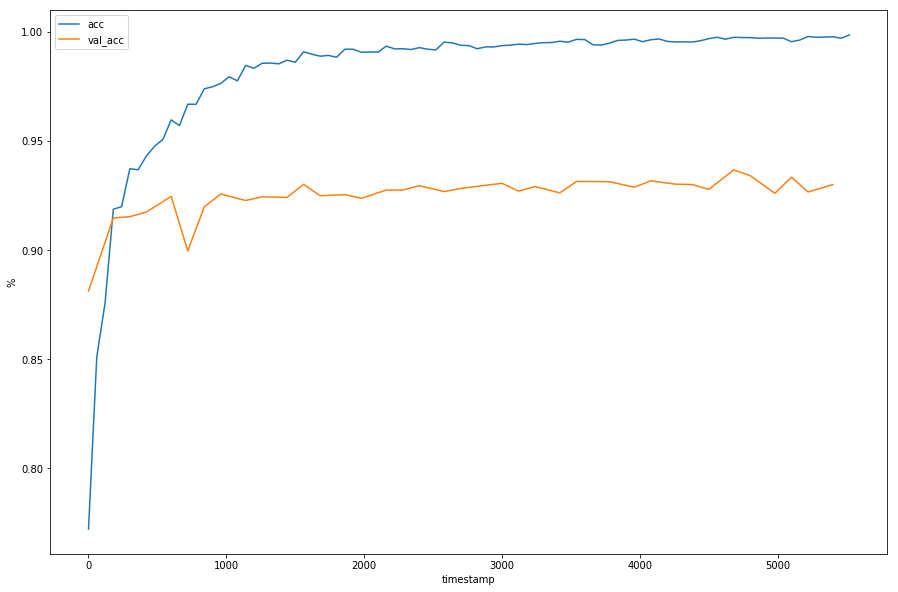

In [124]:
def plot_metrics(metrics_df):
    plt.figure(figsize=(15, 10))
    mask = metrics_df['metric_name'] == 'acc'
    x, y = metrics_df[mask]['timestamp'], metrics_df[mask]['value']
    plt.plot(x, y, label='acc')
    mask = metrics_df['metric_name'] == 'val_acc'
    x, y = metrics_df[mask]['timestamp'], metrics_df[mask]['value']
    plt.plot(x, y, label='val_acc')
    plt.xlabel('timestamp')
    plt.ylabel('%')
    plt.legend()

plot_metrics(metrics_df)

## Automatic tuning

In [18]:
# hyperparameter spaces
conv0_hps = {'conv0_pad': IntegerParameter(1, 3),
             'conv0_channels': IntegerParameter(24, 32),
             'conv0_filter': IntegerParameter(2, 4),
             'conv0_stride': IntegerParameter(1, 3),
             'conv0_pool': IntegerParameter(1, 3),
            }
conv1_hps = {'conv1_pad': IntegerParameter(1, 3),
             'conv1_channels': IntegerParameter(48, 64),
             'conv1_filter': IntegerParameter(2, 4),
             'conv1_stride': IntegerParameter(1, 3),
             'conv1_pool': IntegerParameter(1, 3),
            }
conv2_hps = {'conv2_pad': IntegerParameter(1, 3),
             'conv2_channels': IntegerParameter(96, 128),
             'conv2_filter': IntegerParameter(2, 4),
             'conv2_stride': IntegerParameter(1, 3),
             'conv2_pool': IntegerParameter(1, 3),
            }
fc0_hps = {'fc0_neurons': IntegerParameter(200, 300)}
fc1_hps = {'fc1_neurons': IntegerParameter(200, 300)}

hyperparameter_ranges = {**conv0_hps, **conv1_hps, **conv2_hps, **fc0_hps, **fc1_hps}

# objective and metric
objective_metric_name = 'val_acc'
objective_type = 'Maximize'
metric_definitions = [{'Name': 'val_acc',
                       'Regex': 'best_val_acc: ([0-9\\.]+)'}]

# tuner
tuner = HyperparameterTuner(tf_estimator,
                            objective_metric_name,
                            hyperparameter_ranges,
                            metric_definitions,
                            max_jobs=10,
                            max_parallel_jobs=1,
                            objective_type=objective_type)

In [30]:
tuner.fit({'training': training_input_path, 'validation': validation_input_path})

## Deploy best model

In [116]:
import time

tf_endpoint_name = 'keras-cnn_fashion-mnist-'+time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

tf_predictor = tf_estimator.deploy(initial_instance_count=1,
                         instance_type='ml.c5.large',        # $0.134/hour in eu-west-1
                         accelerator_type='ml.eia1.medium',  # + $0.140/hour in eu-west-1
                         endpoint_name=tf_endpoint_name)     # = 80% discount!

KeyError: 'ModelArtifacts'

## Cleanup

In [ ]:
sess.delete_endpoint(endpoint_name=tf_endpoint_name) 